<a href="https://colab.research.google.com/github/enyeneraph/AVIATION-AIRPLANE-FLIGHTS/blob/main/Premiere_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the necessary packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
sns.set()

Set state

In [2]:
np.random.seed(10)

Reading the data

In [3]:
airplane_dataset = pd.read_csv('https://raw.githubusercontent.com/enyeneraph/AVIATION-AIRPLANE-FLIGHTS/main/Airplane_crashes_dataset_since_1908.csv', parse_dates= ['date'])
airplane_dataset_copy = airplane_dataset.copy()


In [4]:
airplane_dataset.head()

,date,time,location,operator,flight_no,route,ac_type,registration,cn_ln,all_aboard,passengers_aboard,crew_aboard,all_fatalities,passenger_fatalities,crew_fatalities,ground,summary
0,1908-09-17,1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1909-09-07,?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,1912-07-12,630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,1913-08-06,?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,1913-09-09,1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...


In [5]:
airplane_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  5008 non-null   datetime64[ns]
 1   time                  5008 non-null   object        
 2   location              5008 non-null   object        
 3   operator              5008 non-null   object        
 4   flight_no             5008 non-null   object        
 5   route                 5008 non-null   object        
 6   ac_type               5008 non-null   object        
 7   registration          5008 non-null   object        
 8   cn_ln                 5008 non-null   object        
 9   all_aboard            5008 non-null   object        
 10  passengers_aboard     5008 non-null   object        
 11  crew_aboard           5008 non-null   object        
 12  all_fatalities        5008 non-null   object        
 13  passenger_fataliti

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### **Data Cleaning**

Inspecting the dataset

In [7]:
airplane_dataset.head()

,date,time,location,operator,flight_no,route,ac_type,registration,cn_ln,all_aboard,passengers_aboard,crew_aboard,all_fatalities,passenger_fatalities,crew_fatalities,ground,summary
0,1908-09-17,1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1909-09-07,?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,1912-07-12,630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,1913-08-06,?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,1913-09-09,1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...


Dropping columns that are unnecessary to ur analysis

In [8]:
airplane_dataset.drop(columns=['registration', 'flight_no', 'cn_ln', 'time', 'route'], inplace=True)


Replacing '?' in the dataset with np.nan

In [9]:
airplane_dataset = airplane_dataset.replace({'?': np.nan})


Checking for null values

In [10]:
airplane_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  5008 non-null   datetime64[ns]
 1   location              5003 non-null   object        
 2   operator              4998 non-null   object        
 3   ac_type               4995 non-null   object        
 4   all_aboard            4991 non-null   object        
 5   passengers_aboard     4787 non-null   object        
 6   crew_aboard           4789 non-null   object        
 7   all_fatalities        5000 non-null   object        
 8   passenger_fatalities  4773 non-null   object        
 9   crew_fatalities       4773 non-null   object        
 10  ground                4964 non-null   object        
 11  summary               4949 non-null   object        
dtypes: datetime64[ns](1), object(11)
memory usage: 469.6+ KB


In [11]:
airplane_dataset.isna().sum()

date                      0
location                  5
operator                 10
ac_type                  13
all_aboard               17
passengers_aboard       221
crew_aboard             219
all_fatalities            8
passenger_fatalities    235
crew_fatalities         235
ground                   44
summary                  59
dtype: int64

Dealing with inconsistent values

In [12]:
#cleaning the operator column
airplane_dataset['operator'].replace({'Military -Royal Air Force':'Military - Royal Air Force'}, inplace= True)

In [13]:
#capitalize so as to remove duplicates when plotting
airplane_dataset["ac_type"] = airplane_dataset.ac_type.str.upper()
airplane_dataset["operator"] = airplane_dataset.operator.str.upper()
airplane_dataset["location"] = airplane_dataset.location.str.upper()

## **Feature engineering**

Extracting year, month and day from dates

In [14]:
#extracting years from dates
airplane_dataset['year'] = airplane_dataset['date'].dt.year

In [15]:
#extracting months from dates
airplane_dataset['month'] = airplane_dataset['date'].dt.month

In [16]:
#extracting days from dates
airplane_dataset['day'] = airplane_dataset['date'].dt.dayofweek

Splitting operators into military and private

In [17]:
#splitting operators into military and private
airplane_dataset['military_private'] = airplane_dataset['operator'].str.contains('MILITARY')
airplane_dataset['military_private'] = airplane_dataset['military_private'].replace(True, 'military')
airplane_dataset['military_private'] = airplane_dataset['military_private'].replace(False, 'private')

Grouping days as weekday vs weekend

In [18]:
airplane_dataset['day'].value_counts()

1    761
2    754
3    752
4    746
5    721
0    677
6    597
Name: day, dtype: int64

In [19]:
#splitting days into weekday and weekend
weekend = [5, 0]
airplane_dataset['weekday_weekend'] = airplane_dataset['day'].isin(weekend)
airplane_dataset['weekday_weekend'] = airplane_dataset['weekday_weekend'].replace(True, 'Weekend')
airplane_dataset['weekday_weekend'] = airplane_dataset['weekday_weekend'].replace(False, 'Weekday')


Extracing country from location

In [20]:
def split_country(x):
  a = x.split(",")[-1].strip()

  return a

In [21]:
airplane_dataset['country'] = airplane_dataset[airplane_dataset['location'].notna()]['location'].apply(split_country)

In [22]:
#defining US states and capitals
us_regions = ['Alabama', 'Montgomery', 'Alaska','Juneau', 'Arizona', 'Phoenix', 'Arkansas', 'Little Rock', 'California', 'Sacremento','Colorado', 'Denver', 'Connecticut', 'Hartford','Delaware', 'Dover',
'Florida', 'Tallahassee','Georgia', 'Atlanta', 'Hawaii','Honolulu', 'Idaho', 'Boise','Illinois', 'Springfield', 'Indiana', 'Indianapolis', 'Iowa', 'Des Moines', 'Kansas', 'Topeka', 'Kentucky', 'Frankfort', 'Louisiana', 'Baton Rouge',
'Maine', 'Augusta','Maryland', 'Annapolis','Massachusetts', 'Boston','Michigan', 'Lansing', 'Minnesota', 'St. Paul', 'Mississippi', 'Jackson', 'Missouri', 'Jefferson City',
'Montana', 'Helena', 'Nebraska', 'Lincoln', 'Nevada', 'Carson City', 'New Hampshire', 'Concord', 'New Jersey', 'Trenton', 'New Mexico', 'Santa Fe', 'New York', 'Albany','North Carolina', 'Raleigh',
'North Dakota', 'Bismarck', 'Ohio', 'Columbus','Oklahoma', 'Oklahoma City','Oregon', 'Salem','Pennsylvania', 'Harrisburg','Rhode Island', 'Providence','South Carolina', 'Columbia','South Dakota',    'Pierre',
'Tennessee', 'Nashville','Texas', 'Austin', 'Utah', 'Salt Lake City', 'Vermont' , 'Montpelier', 'Virginia', 'Richmond', 'Washington', 'Olympia', 'West Virginia', 'Charleston', 'Wisconsin', 'Madison',
'Wyoming', 'Cheyenne']
us_regions = [i.upper() for i in us_regions]
us_regions


['ALABAMA',
 'MONTGOMERY',
 'ALASKA',
 'JUNEAU',
 'ARIZONA',
 'PHOENIX',
 'ARKANSAS',
 'LITTLE ROCK',
 'CALIFORNIA',
 'SACREMENTO',
 'COLORADO',
 'DENVER',
 'CONNECTICUT',
 'HARTFORD',
 'DELAWARE',
 'DOVER',
 'FLORIDA',
 'TALLAHASSEE',
 'GEORGIA',
 'ATLANTA',
 'HAWAII',
 'HONOLULU',
 'IDAHO',
 'BOISE',
 'ILLINOIS',
 'SPRINGFIELD',
 'INDIANA',
 'INDIANAPOLIS',
 'IOWA',
 'DES MOINES',
 'KANSAS',
 'TOPEKA',
 'KENTUCKY',
 'FRANKFORT',
 'LOUISIANA',
 'BATON ROUGE',
 'MAINE',
 'AUGUSTA',
 'MARYLAND',
 'ANNAPOLIS',
 'MASSACHUSETTS',
 'BOSTON',
 'MICHIGAN',
 'LANSING',
 'MINNESOTA',
 'ST. PAUL',
 'MISSISSIPPI',
 'JACKSON',
 'MISSOURI',
 'JEFFERSON CITY',
 'MONTANA',
 'HELENA',
 'NEBRASKA',
 'LINCOLN',
 'NEVADA',
 'CARSON CITY',
 'NEW HAMPSHIRE',
 'CONCORD',
 'NEW JERSEY',
 'TRENTON',
 'NEW MEXICO',
 'SANTA FE',
 'NEW YORK',
 'ALBANY',
 'NORTH CAROLINA',
 'RALEIGH',
 'NORTH DAKOTA',
 'BISMARCK',
 'OHIO',
 'COLUMBUS',
 'OKLAHOMA',
 'OKLAHOMA CITY',
 'OREGON',
 'SALEM',
 'PENNSYLVANIA',
 'HARRISB

In [23]:
#defining canada states and capital
canada_regions = ['Alberta	Edmonton','British Columbia','Victoria', 'Manitoba', 'Winnipeg', 'Brunswick',	'New Brunswick'	'Fredericton', 'Newfoundland and Labrador', "St. John's"
'Northwest Territories', 'Yellowknife','Nova Scotia','Halifax', 'Nunavut',	'Iqaluit', 'Ontario', 'Toronto', 'Prince Edward Island',	'Charlottetown', 'Quebec',	'Québec City','Saskatchewan','Regina',
'Yukon',	'Whitehorse']

canada_regions = [i.upper() for i in canada_regions]

In [24]:
#replacing states and capitals of USA in the dataset with 'USA'
airplane_dataset['country'].replace(us_regions, 'USA', inplace=True)

In [25]:
#replacing canada states/capitals with Canada
airplane_dataset['country'].replace(canada_regions, 'CANADA', inplace = True)


**Adding a decade column**


In [26]:
airplane_dataset['decade'] = (airplane_dataset['year']//10) * 10
airplane_dataset['decade'] = airplane_dataset['decade'].apply(str) + 's'


In [27]:
airplane_dataset['decade'].head(5)

0    1900s
1    1900s
2    1910s
3    1910s
4    1910s
Name: decade, dtype: object

## **Exploratory Data Analysis and Visualizations**

##**An analysis of accident occurence by dates**

**Count of accidents by decade**

In [59]:
#obtaining the counts of accidents per decade
df = airplane_dataset.groupby('decade')['date'].count().reset_index()

[Text(0, 0.5, 'Number of accidents'), Text(0.5, 0, 'Decade')]

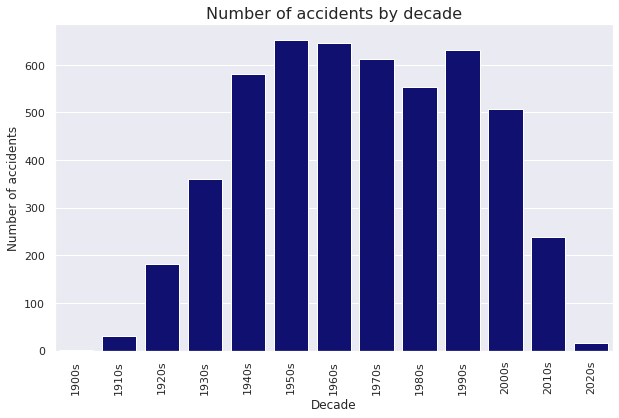

In [60]:
#plotting the bar chart
plt.figure(figsize= (10, 6))
plt.xticks(rotation= 90)
g = sns.barplot(x='decade', y= 'date', data= df, color='navy')
# plt.xlabel('Decade')
# plt.ylabel('Number of accidents')
plt.title('Number of accidents by decade', fontdict= {'fontsize' : 16})
g.set(xlabel= 'Decade', ylabel = 'Number of accidents')


Insight/Observation: From our analysis above, we see that the number of accidents increases significantly in every decade starting from the 1910s and reaching its peak in the 1950s, a decade marked by the post-World War II boom.
It decreases in suceeding decades except in the 1990s where it witnesses another significant increase.

**Growth rate of accidents yearly**

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Count of accidents per year')]

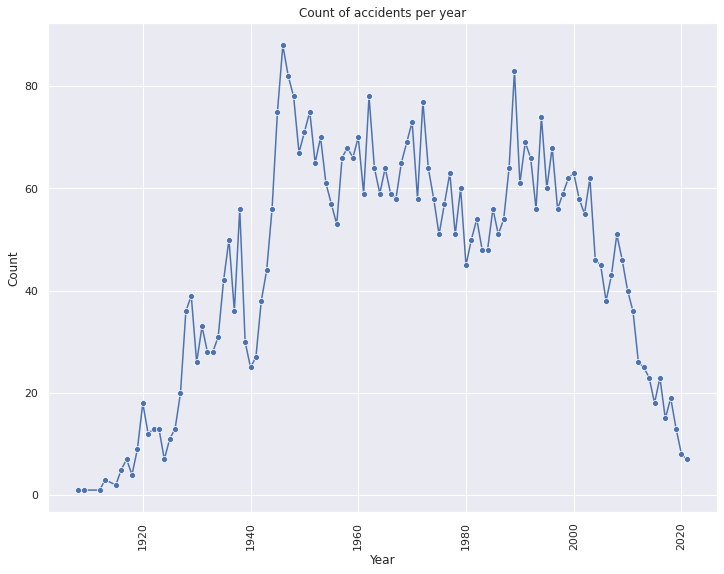

In [61]:
#no accidents by year
df = airplane_dataset.groupby('year')['date'].count().reset_index()
plt.figure(figsize=(12,9))
g = sns.lineplot(data=df,x = 'year', y= 'date', marker='o')
plt.xticks(rotation= 90)
g.set( xlabel = "Year", ylabel = "Count", title= 'Count of accidents per year')


Inferences/Insights:
Zooming in on the yearly occurence of accidents, we observe that the year 1946 records the highest occurence of airline accidents.
We can also see clearly the increasing nature of accidents from 1940 up untill 1946, a period marked by the World War II(1939 - 1945)

**Number of accidents per month**

[Text(0, 0.5, 'Count'),
 [Text(0, 0, 'Jan'),
  Text(0, 0, 'Feb'),
  Text(0, 0, 'Mar'),
  Text(0, 0, 'Apr'),
  Text(0, 0, 'May'),
  Text(0, 0, 'Jun'),
  Text(0, 0, 'Jul'),
  Text(0, 0, 'Aug'),
  Text(0, 0, 'Sep'),
  Text(0, 0, 'Oct'),
  Text(0, 0, 'Nov'),
  Text(0, 0, 'Dec')],
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Count of accidents per month')]

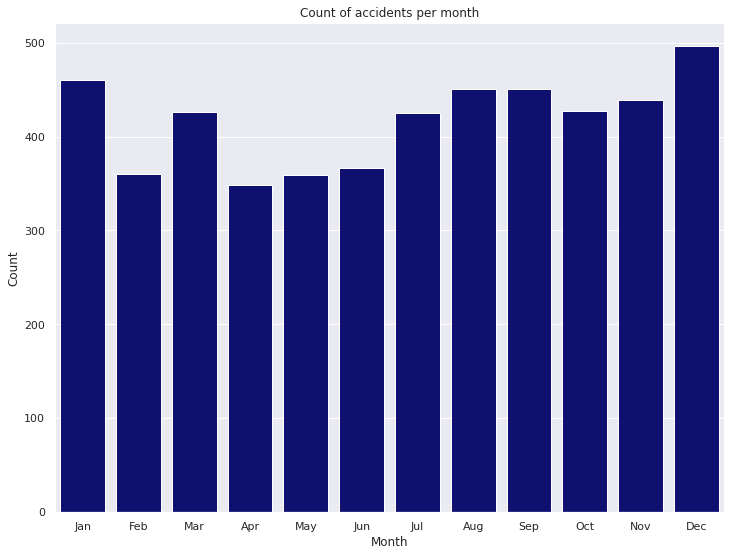

In [62]:
#no accidents by month
df = airplane_dataset.groupby('month')['date'].count().reset_index()
plt.figure(figsize=(12,9))
g = sns.barplot(x = 'month', y= 'date', data = df, color= 'navy')
g.set( xlabel = "Month", ylabel = "Count", title= 'Count of accidents per month', xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

Observations:
The month of April records the least occurence of accidents, while December and January record the highest and second highest occurence of accidents, two months marked by festive celebrations and holidays.

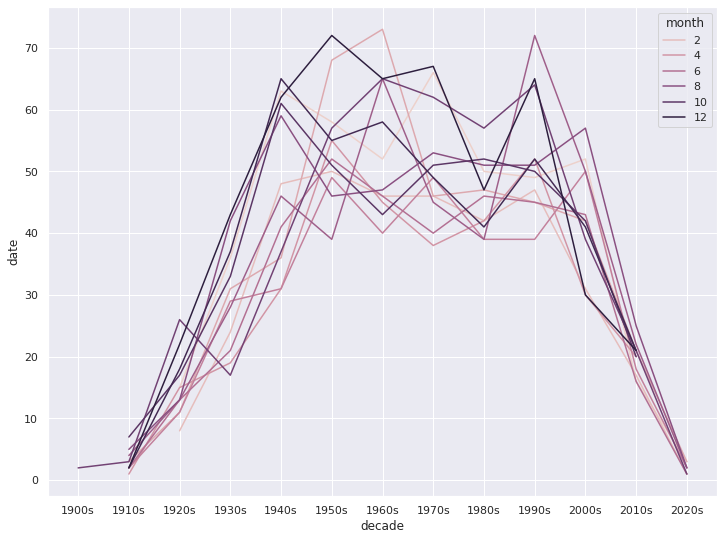

In [63]:
#observing the trend of accidents accross months

df = airplane_dataset.groupby(['decade', 'month'])['date'].count().reset_index()
plt.figure(figsize=(12,9))
g = sns.lineplot(data=df,x ='decade', y= 'date' , hue= 'month')


Observations: The occurence of accidents across most months take a dip around the 1950s to 19980s.

**Number of accidents by day of week**


[Text(0, 0.5, 'Count'),
 [Text(0, 0, 'Monday'),
  Text(0, 0, 'Tuesday'),
  Text(0, 0, 'Wednesday'),
  Text(0, 0, 'Thursday'),
  Text(0, 0, 'Friday'),
  Text(0, 0, 'Saturday'),
  Text(0, 0, 'Sunday')],
 Text(0.5, 0, 'Day of the Week'),
 Text(0.5, 1.0, 'Count of accidents per day')]

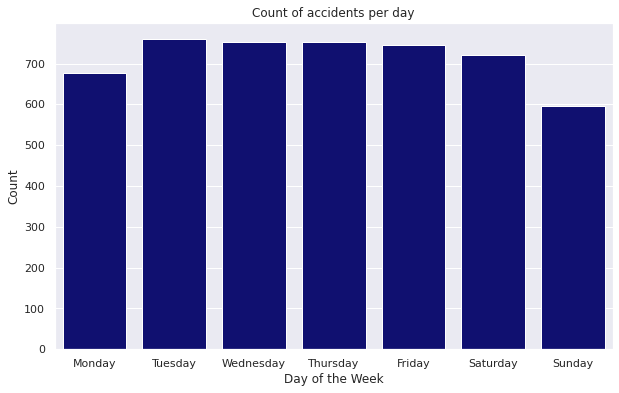

In [64]:
#no of accident by day of the week
df = airplane_dataset.groupby('day')['date'].count().reset_index()
plt.figure(figsize=(10, 6))
g = sns.barplot(x = 'day', y= 'date', data = df, color= 'navy')
g.set( xlabel = "Day of the Week", ylabel = "Count", title= 'Count of accidents per day', xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Observation:
Monday and Sunday record the least occurence of accidents while the rest of the days have an almost equal likelihood of housing an airline accident.

**Proportion of accidents in weekday and workday**


In [65]:
#no of accident by weekend/weekday 
df = airplane_dataset.groupby('weekday_weekend')['date'].count().reset_index()
df.head()

,weekday_weekend,date
0,Weekday,3610
1,Weekend,1398


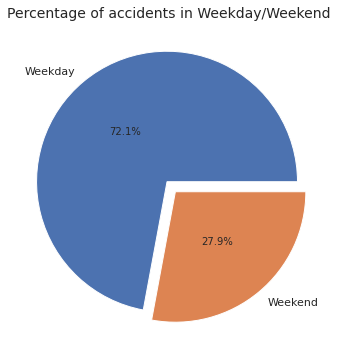

In [66]:
#accidents by weekday vs weekend
pie, ax = plt.subplots(figsize=[10,6])
labels = ['Weekday','Weekend']
plt.pie(x=df['date'], autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Percentage of accidents in Weekday/Weekend ", fontsize=14);


Observations:
The occurence of accidents on weekdays is higher than on weekends. This could be attributed to the number of flights taken on weekdays compared to weekends.

##**An analysis of accident occurence by countries**

In [36]:
#summary statistics on accidents by countries

airplane_dataset['country'].describe()

count     5003
unique     465
top        USA
freq      1011
Name: country, dtype: object

**Top 15 Countries with the most accidents**

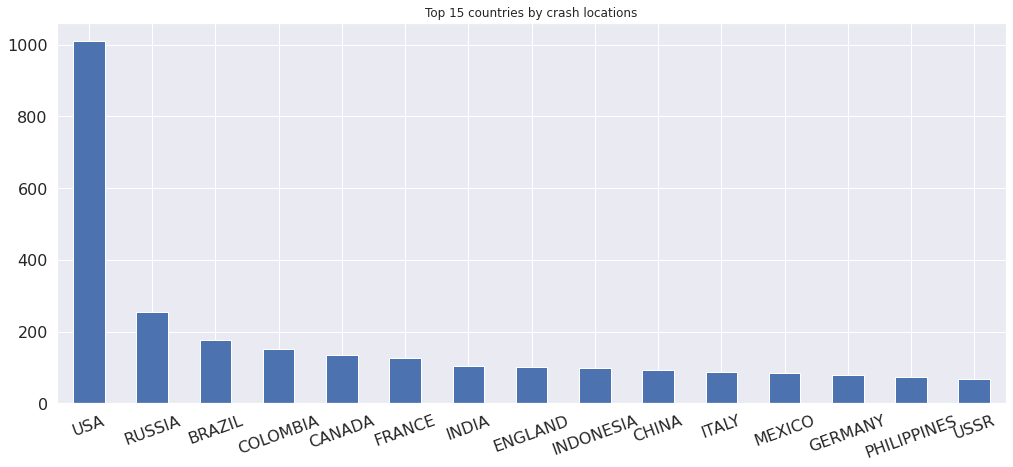

In [37]:
#top 15 countries with the most accidents
airplane_dataset['country'].value_counts()[:15].plot(kind='bar',  figsize=(17,7), rot=20, fontsize=16, title="Top 15 countries by crash locations")


Observation: USA has the highest occurence of accidents compared to the other countries.

**Countries with the most accidents from 2000 to 2021**

In [38]:
#countries with the most accidents from 2000 to 2021
dataset_from_last_21years = airplane_dataset[airplane_dataset['year'].between(2000, 2021)]
dataset_from_last_21years= dataset_from_last_21years.groupby('country')['year'].count().reset_index().nlargest(n= 10, columns= 'year')


Text(0.5, 1.0, 'Top 10 countries with the most accidents in 2000-2021')

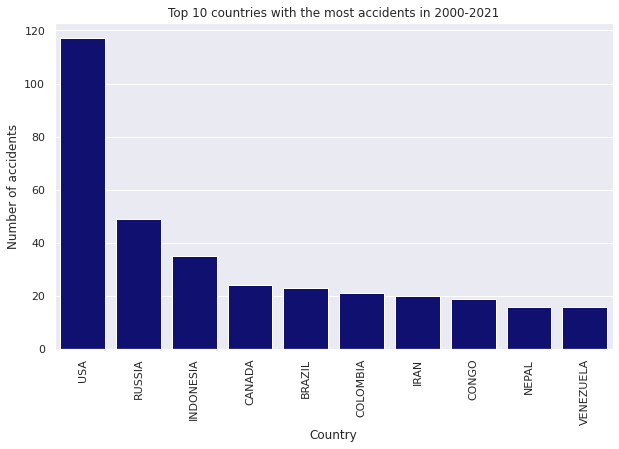

In [39]:
#plotting the bar chart
plt.figure(figsize= (10, 6))
plt.xticks(rotation= 90)
sns.barplot(x='country', y= 'year', data= dataset_from_last_21years, color='navy')
plt.xlabel('Country')
plt.ylabel('Number of accidents')
plt.title('Top 10 countries with the most accidents in 2000-2021')

Observations/Insights:
In the past 21 years, the United States of America has recorded the highest occurence of accidents, almost triple the number of accidents in the second highest country.
Also worthy of note, is Indonesia's position as the third highest country whereas in the overall count earlier shown, it is the 9th country.

##**Aircraft type**

**Number of accidents by aircraft type**

In [40]:
airplane_dataset['ac_type'].describe()

count             4995
unique            2415
top       DOUGLAS DC-3
freq               333
Name: ac_type, dtype: object

In [41]:
#no of accidents by aircraft type
accidents_by_actype = airplane_dataset.groupby('ac_type')['date'].count().reset_index()


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Aircraft_type'),
 Text(0.5, 1.0, 'Aircrafts with the most accidents(top ten)')]

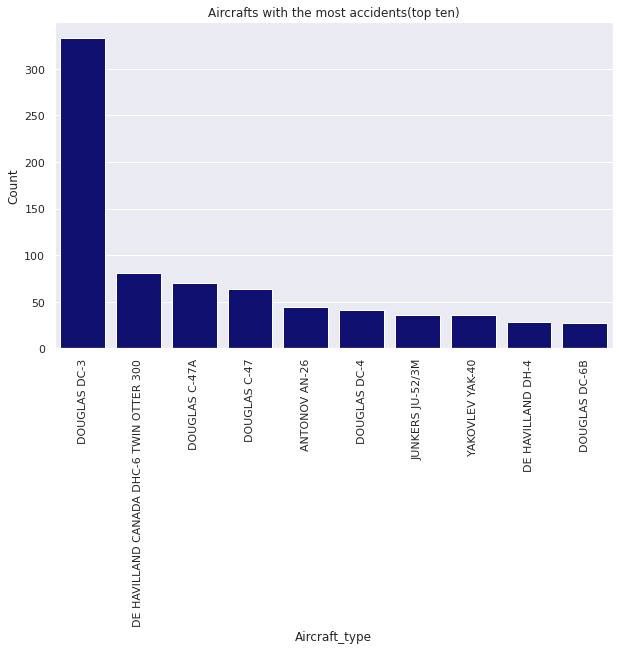

In [42]:
accidents_by_actype = accidents_by_actype.sort_values(by=['date'], ascending=False)
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
g = sns.barplot(x = 'ac_type', y= 'date', data = accidents_by_actype[:10], color= 'navy')
g.set( xlabel = "Aircraft_type", ylabel = "Count", title= 'Aircrafts with the most accidents(top ten)')


Observations: 6 out of 10 of the top ten aircraft types record occurences of accidents below 50. The other 4 record an accident occurence above 50, with the Douglas DC-3 aircraft topping the list with 333 accident occurences.


##**Aircraft Operators**

In [43]:
#summary statistics on accident occurence by aircraft operators

airplane_dataset['operator'].describe()

count         4998
unique        2256
top       AEROFLOT
freq           253
Name: operator, dtype: object

**Aircraft operators with the most accidents**

In [44]:
#top 10 operators with the most accidents
accidents_by_operator = airplane_dataset.groupby('operator')['date'].count().reset_index()

In [77]:
accidents_by_operator.describe()

,date
count,2256.000000
mean,2.215426
std,7.350741
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,253.000000


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Operator'),
 Text(0.5, 1.0, 'Count of accidents( Top ten operators)')]

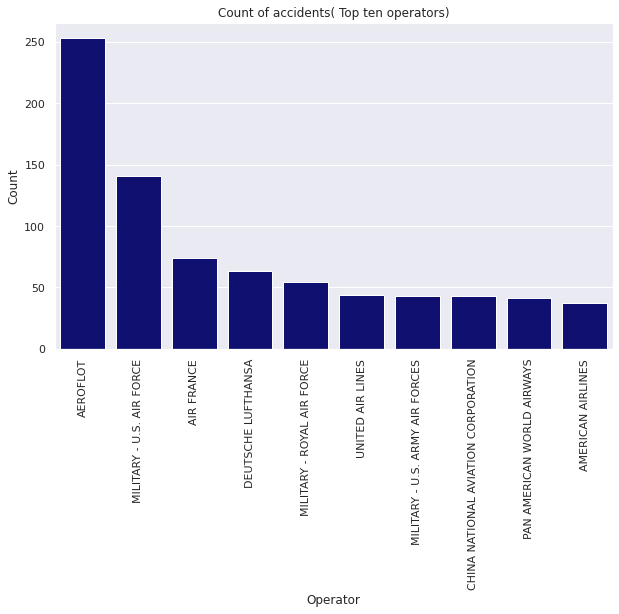

In [79]:
accidents_by_operator = accidents_by_operator.sort_values(by=['date'], ascending=False)
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
g = sns.barplot(x = 'operator', y= 'date', data = accidents_by_operator[:10], color='navy')
g.set( xlabel = "Operator", ylabel = "Count", title= 'Count of accidents( Top ten operators)')

Observation: 
While Aeroflot, a Russian airline with about 253 accidents is the airline operator with the highest number of accidents, we see that 5 out of the 10 airlines operators are based in the United States.

**Percentage of accidents by military/private operator**


In [46]:
#no of accident by military/private operator
df = airplane_dataset.groupby('military_private')['date']. count().reset_index()
df.head()

,military_private,date
0,military,762
1,private,4236


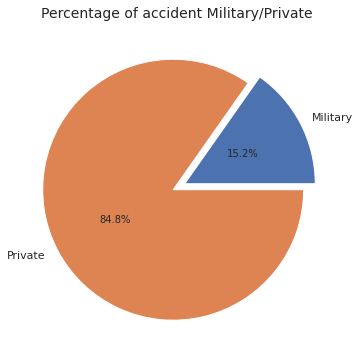

In [47]:
pie, ax = plt.subplots(figsize=[10,6])
labels = ['Military','Private']
plt.pie(x=df['date'], autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Percentage of accident Military/Private ", fontsize=14);

Observations: We can see clearly from the analysis  above that private airlines have accounted for more than half of the accidents in the years covered by our dataset.


##**Fatalities**

**Top 15 countries based on average fatalities per crash**


In [48]:
#convering the fatalities dtype to float
airplane_dataset["all_fatalities"] = pd.to_numeric(airplane_dataset["all_fatalities"], downcast="float")

In [76]:
average_Fpc = airplane_dataset.groupby(['country'])['all_fatalities'].mean().reset_index().sort_values(by= 'all_fatalities', ascending= False)

average_Fpc.describe()

,all_fatalities
count,465.000000
mean,23.883492
std,32.552437
min,0.000000
25%,8.000000
50%,16.000000
75%,27.000000
max,329.000000


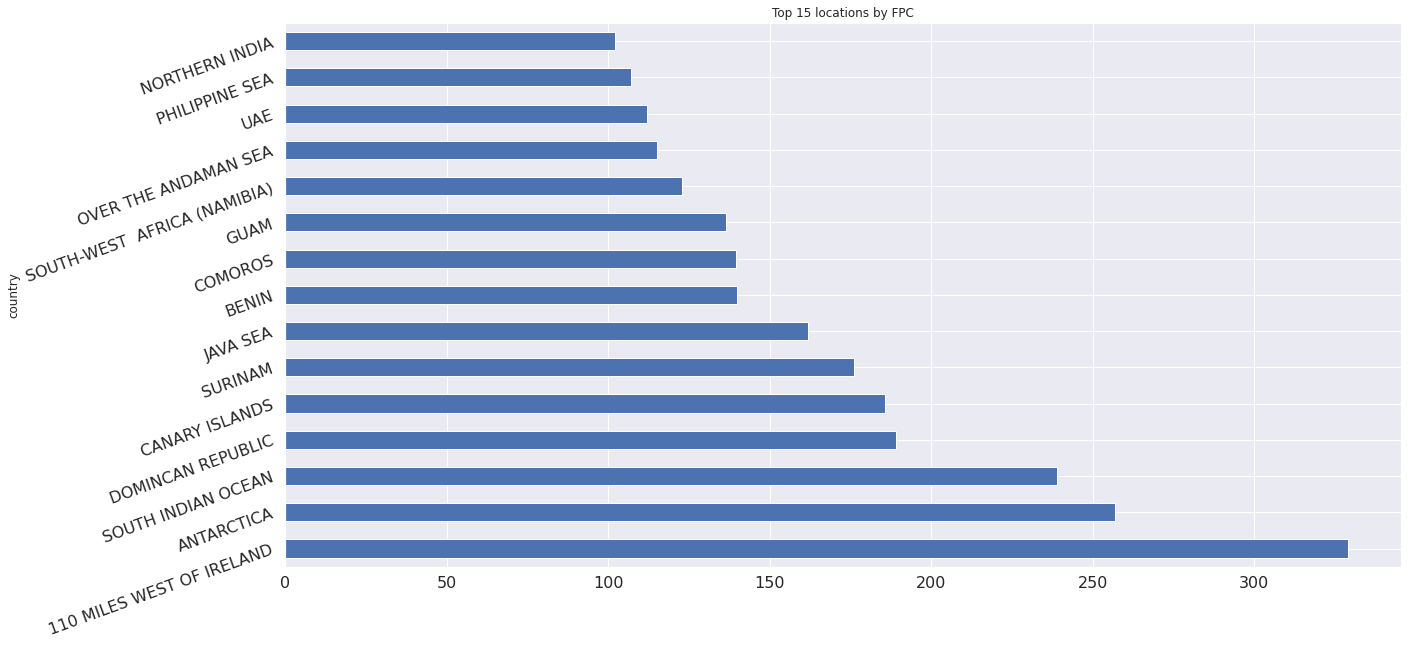

In [75]:
average_Fpc = airplane_dataset.groupby(['country'])['all_fatalities'].mean().sort_values(ascending= False)
average_Fpc[:15].plot(kind='barh', figsize=(20,10), rot=20, fontsize=16, title="Top 15 locations by FPC")

Insight/Observation: We see that on the country level, the countries with high number of airplane crashes do not necessarily correspond to high fatality per crush.


**Proportion of fatalities to people aboard**


In [50]:

df = airplane_dataset.copy()
df['all_fatalities'] = df['all_fatalities'].replace(np.nan, '0')
df['all_aboard'] = df['all_aboard'].replace(np.nan, '0')
df['all_fatalities'] = df['all_fatalities'].astype(int)
df['all_aboard'] = df['all_aboard'].astype(int)
df = df.groupby(['year']).agg({"all_aboard":"sum","all_fatalities":"sum"}).reset_index()


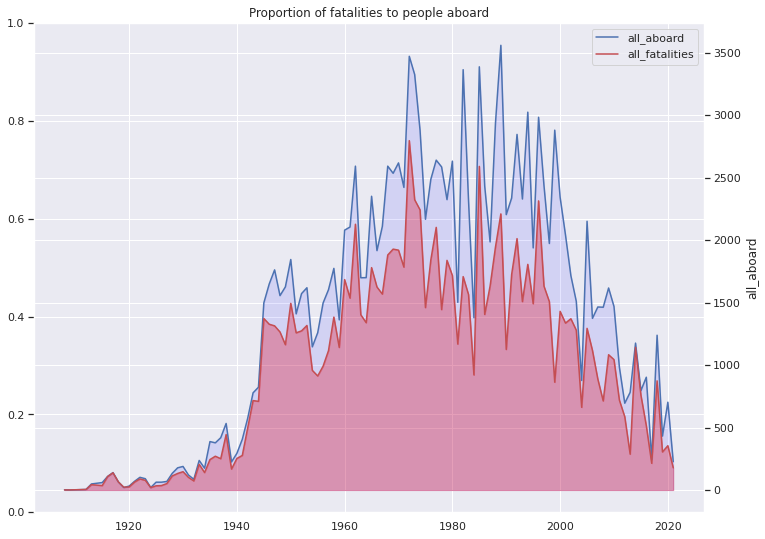

In [51]:
#plotting the graph

plt.figure(figsize=(12,9))
g2 = plt.twinx()
sns.lineplot(data = df, x = df['year'], y = df['all_aboard'] ,color="b")

sns.lineplot(data = df, x = df['year'], y = df['all_fatalities'] ,color="r", ax = g2)
plt.legend(labels=['all_aboard','all_fatalities'])
g2.set(  title= 'Proportion of fatalities to people aboard')
plt.fill_between(df['year'], df['all_fatalities'], color="red", alpha=0.3)
plt.fill_between(df['year'], df['all_aboard'], color="blue", alpha=0.1)
plt.show()


Insight/Observation:
While the number of fatalities increases with the number of people aboard as expected, we can also observe an increased survival rate in the years following 1945